In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=2, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.0
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

train_lables_file = './cifar10/trainLabels.csv'
test_csv_file = './cifar10/sampleSubmission.csv'
train_folder = './cifar10/train/'


def parse_csv_file(filepath, folder):
    """Parses csv files into (filename(path), label) format"""
    results = []
    with open(filepath, 'r') as f:
        lines = f.readlines()[1:]
    for line in lines:
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder, image_id + '.png')
        results.append((image_full_path, label_str))
    return results

train_labels_info = parse_csv_file(train_lables_file, train_folder)


import pprint
pprint.pprint(train_labels_info[0:5])
print(len(train_labels_info))

[('./cifar10/train/1.png', 'frog'),
 ('./cifar10/train/2.png', 'truck'),
 ('./cifar10/train/3.png', 'truck'),
 ('./cifar10/train/4.png', 'deer'),
 ('./cifar10/train/5.png', 'automobile')]
50000


In [3]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])


train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())


                filepath       class
0  ./cifar10/train/1.png        frog
1  ./cifar10/train/2.png       truck
2  ./cifar10/train/3.png       truck
3  ./cifar10/train/4.png        deer
4  ./cifar10/train/5.png  automobile
                    filepath       class
0  ./cifar10/train/45001.png       horse
1  ./cifar10/train/45002.png  automobile
2  ./cifar10/train/45003.png        deer
3  ./cifar10/train/45004.png  automobile
4  ./cifar10/train/45005.png    airplane


### 使用到keras的封装好的API对图片进行增强处理

In [4]:
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    class_mode = 'sparse',## sparse对应位onehot前的类别id， 如果设为：categorical 则为onehot后的编码
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [5]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]
(32, 32, 32, 3) (32,)
[0. 7. 2. 7. 5. 5. 7. 0. 5. 4. 9. 7. 6. 3. 0. 4. 4. 4. 6. 3. 5. 4. 6. 6.
 4. 1. 8. 2. 4. 4. 3. 0.]


### 使用resnet50模型，从新训练

In [6]:
resnet50_model = keras.models.Sequential()
resnet50_model.add(keras.applications.ResNet50(include_top = False,# 不许要做后一层，因为标准的resnet结果是1000类，这边是10类的
                                                   pooling = 'avg'))#,# 倒数第二层是矩阵，需要展平或pooling
                                                   #weights = 'imagenet'))## 默认null，会重新训练； imagenet会去下载一个训练好的模型参数来初始化网络结构
resnet50_model.add(keras.layers.Dense(num_classes,activation = 'softmax'))#10分类

# resnet50_model.layers[0].trainable = False # 因为是去下载训练好的参数，所以不需要训练第一层

resnet50_model.compile(loss="sparse_categorical_crossentropy",
                           optimizer="sgd", metrics=['accuracy'])

resnet50_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-4),## 5次epochs内提升在0.0001内，提前退出
]

In [12]:
%%time
epochs = 300

history = resnet50_model.fit_generator(train_generator,
                                      steps_per_epoch = train_num // batch_size,
                                      epochs = epochs,
                                      validation_data = valid_generator,
                                      validation_steps = valid_num // batch_size)#,
                                      #callbacks = callbacks)

Epoch 1/300
1406/1406 [==============================] - 254s 180ms/step - loss: 0.5404 - accuracy: 0.8121 - val_loss: 0.5585 - val_accuracy: 0.8097
Epoch 2/300
1406/1406 [==============================] - 250s 178ms/step - loss: 0.5408 - accuracy: 0.8112 - val_loss: 0.6235 - val_accuracy: 0.7935
Epoch 3/300
1406/1406 [==============================] - 249s 177ms/step - loss: 0.5386 - accuracy: 0.8110 - val_loss: 0.6235 - val_accuracy: 0.7935
Epoch 4/300
1406/1406 [==============================] - 251s 178ms/step - loss: 0.5353 - accuracy: 0.8123 - val_loss: 0.6080 - val_accuracy: 0.8013
Epoch 5/300
1406/1406 [==============================] - 253s 180ms/step - loss: 0.5264 - accuracy: 0.8152 - val_loss: 0.5130 - val_accuracy: 0.8255
Epoch 6/300
1406/1406 [==============================] - 249s 177ms/step - loss: 0.5146 - accuracy: 0.8180 - val_loss: 0.5956 - val_accuracy: 0.8019oss: 0.5136 - accuracy: 
Epoch 7/300
1406/1406 [==============================] - 251s 179ms/step - loss: 0

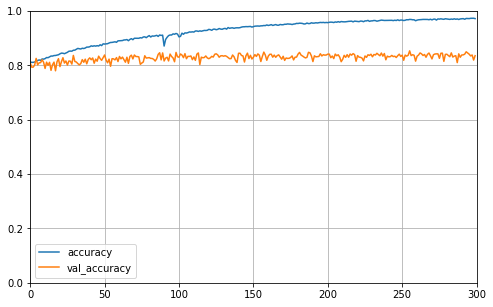

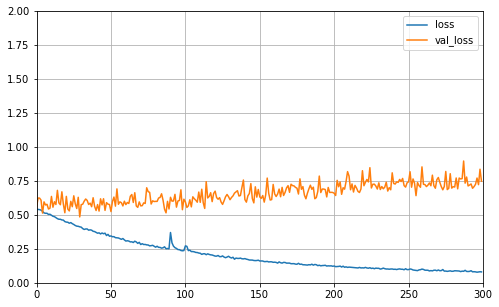

In [13]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)




In [14]:
## 保存模型结构
mdir = os.path.join("./save_model/resnet50_0320" )
if not os.path.exists(mdir):
    os.mkdir(mdir)
tf.saved_model.save(resnet50_model,mdir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./save_model/resnet50_0320\assets
